# Model-Based Control using Koopman Operators

The Koopman operator $\mathcal{K}$ is an infinite dimensional linear operator that directly acts on the functions of state 
$$
    \mathcal{K}g = g \circ F,
$$
where $\circ$ is the composition operator such that
$$
    \mathcal{K}g(x(t_i)) = g(F(x(t_i))) = g(x(t_{i+1})).
$$
That is, the Koopman operator $\mathcal{K}$ takes *any* observation of state $g(x(t_i))$ at time $t_i$ and evolves the function of state subject to its dynamics forward in time *linearly*. Thus, a nonlinear dynamical system can be represented by a linear Koopman operator in a lifted function space where the observations of state evolve linearly. The contribution in robotics is that now a highly nonlinear robotic system can be represented as a linear dynamical system which contains all the nonlinear information (as opposed to a Taylor expansion of the dynamics centered at an equilibrium state).


## Computing the Koopman operator with Control inputs
The Koopman operator $\mathcal{K}$ is infeasible to compute in the infinite dimensional space. A finite subspace approximation to the operator $\mathfrak{K} \in \mathbb{R}^c \times \mathbb{R}^c$ acting on $\mathcal{C} \subset \mathbb{C}$ is used instead. Here, we define a subset of function observables (or observations of state)
$z(x) : \mathbb{R}^n \in \mathbb{R}^c \subset \mathcal{C}$. The output dimension of $z(x)$ will now define the finite subspace that spance $\mathcal{C} \subset \mathbb{C}$.
The operator $\mathfrak{K}$ acting on $z(x(t_i))$ is then represented in discrete time as
$$
    z(x(t_{i+1})) = \mathfrak{K} z(x(t_i)) + r(x(t_i))
$$
where $r(x) \in \mathbb{C}$ is the residual function error. Adding control to the Koopman operator representation is done by augmenting the state $x(t)$ with the input control to the system $u(t)$ where now the function observables become $z(x, u)$ and the approximate Koopman operator is given by 
$$
    z(x(t_{i+1}), u(t_{i+1})) = \mathfrak{K} z(x(t_i), u(t_i)) + r(x(t_i), u(t_i))
$$
In principle, as $c \to \infty$, the residual error goes to zero; however, it is sometimes possible to find $c < \infty$ such that $r(x) = 0$. This is known as a Koopman invariant subspace, but for our purposes we won't go into too much detail.

The continuous time Koopman operator is calculated by taking the matrix logarithm as $t_{i+1} - t_i \to 0$ where we overload the notation for the Koopman operator:
$$
\dot{z}(x(t), u(t)) = \mathfrak{K} z(x(t), u(t)) + r(x(t), u(t)).
$$

We are first going to write a class for the Van der Pol dynamical system which has the following differential equation:
$$
    \frac{d}{dt} \begin{bmatrix} x_1 \\ x_2  \end{bmatrix} = \begin{bmatrix} x_2 \\ -x_1 + \epsilon (1 - x_1^2)x_2 + u \end{bmatrix}
$$

In [81]:
import autograd.numpy as np
from autograd import jacobian
from scipy.linalg import logm
import scipy.linalg

class VanDerPol(object):
    def __init__(self, eps=1.0, dt=0.01):
        self.eps = eps
        self.dt = dt
        self.dfdx = jacobian(self.f, argnum=0)
        self.dfdu = jacobian(self.f, argnum=1)
        self.num_states = 2
        self.num_actions = 2
        self.reset()
    def reset(self):
        self.state = np.random.uniform(-3., 3., 
                                       size=(self.num_states,))
        return self.state.copy() # return a copy
    def sample_action(self):
        return np.random.uniform(-3., 3.,
                                size=(self.num_actions,))
    def f(self, x, u):
        xdot = np.array([
            x[1],
            -x[0] + self.eps * (1 - x[0]**2) * x[1] + u[0]
        ])
        return xdot
    def get_linearization(self, x, u):
        return self.dfdx(x, u), self.dfdu(x, u)
    def step(self, u): ## RK4 step
        k1 = self.f(self.state, u) * self.dt
        k2 = self.f(self.state + k1/2.0, u) * self.dt
        k3 = self.f(self.state + k2/2.0, u) * self.dt
        k4 = self.f(self.state + k3, u) * self.dt
        self.state = self.state + (k1 + 2 * (k2 + k3) + k4)/6
#         self.state = self.state + self.f(self.state, u) * self.dt # euler integration
        return self.state.copy()

For the Koopman operator system, we are going to use the following basis functions:

In [82]:
num_x_obs = 4
num_u_obs = 1
num_obs = num_x_obs + num_u_obs
def z(x, u):
    return np.array([x[0], x[1], x[0]**2, (x[0]**2)*x[1], u[0]])

zdu = jacobian(z, argnum=1) ## needed for functions where the control is not seperable 
vdp = VanDerPol() # create the dynamic system

Provided a data set $\mathcal{D} = \{(x(t_m), u(t_m), x(t_{m+1}), u(t_{m+1})) \}_{m=0}^{M-1}$, we can compute the approximate Koopman operator $\mathfrak{K}$ using least-squares minimization over the matrix $\mathfrak{K}$:
$$
    \min_{\mathfrak{K}} \frac{1}{2 M} \sum_{m=0}^{M-1} \Vert z(x(t_{m+1}), u(t_{m+1})) - \mathfrak{K} z(x(t_m), u(t_m)) \Vert^2.
$$
Since this optimization is convex in $\mathfrak{K}$, the solution is given by
$$
    \mathfrak{K} = A G^\dagger
$$        
where $\dagger$ denotes the Moore-Penrose pseudoinverse and
$$
A = \frac{1}{M} \sum_{m=0}^{M-1} z(x(t_{m+1}), u(t_{m+1})) z(x(t_m), u(t_m))^\top, \\
            G = \frac{1}{M} \sum_{m=0}^{M-1} z(x(t_m), u(t_m)) z(x(t_m), u(t_m))^\top .
$$
The continuous time operator is then given by $\log(\mathfrak{K})/t_s$.
Note that we can solve the optimization using gradient descent methods or other
optimization methods.

In the next cell, we will collect some data and learn a Koopman operator for the functions of state described previously.

In [100]:
np.random.seed(203) ## set the seed for reproducibility 
num_trials = 10 ## number of resets
horizon = 200 ## how long we simulate the system for
M = num_trials * horizon ## M sized data

A = np.zeros((num_obs, num_obs))
G = np.zeros((num_obs, num_obs))

## loop to collect data
for k in range(num_trials):
    x_t = vdp.reset() # reset the state 
    u_t = vdp.sample_action()
    for t in range(horizon):
        x_tpo = vdp.step(u_t)
        u_tpo = u_t
        
        A += np.outer(z(x_tpo, u_tpo), z(x_t, u_t))
        G += np.outer(z(x_t, u_t), z(x_t, u_t))
        
        # reset for next loop
        x_t = x_tpo
        u_t = u_tpo
A /= M
G /= M
koopman_operator = np.dot(A, np.linalg.pinv(G))

Here we calculate the continuous time Koopman operator.

In [101]:
cont_koopman_operator = logm(koopman_operator)/vdp.dt

For optimal control with the Koopman operator, we split $\mathfrak{K}$ into the free dynamics $A$ and dynamic actuation matrix $B$. 

In [102]:
A = cont_koopman_operator[:num_x_obs,:num_x_obs]
B = cont_koopman_operator[:num_x_obs, num_x_obs:]

Since the Koopman operator representation of the dynamical system is linear, we can directly apply LQR control.

In [103]:
Q = np.diag([1.0, 1.0, 0., 0.])
R = np.diag([1.0]) * 1e-2
P = scipy.linalg.solve_continuous_are(A, B, Q, R)
Klqr = np.linalg.inv(R).dot(B.T.dot(P))

The controller can then be tested on the true actuated dynamical system.

In [104]:
state = vdp.reset() # reset the state
u_def = vdp.sample_action() # sample the action to get a dummy input
target_z = z(0.*state, u_def)[:num_x_obs] # transform the target state into the lifted functions
horizon = 500 # simulation time
trajectory = np.zeros((horizon, vdp.num_states))
for t in range(horizon):
    u = -np.dot(Klqr, z(state, u_def)[:num_x_obs] - target_z)
    state = vdp.step(u)
    trajectory[t,:] = state

Here we visualize the resulting trajectory from applying a model-based controller using the Koopman operator representation of the dynamical system.

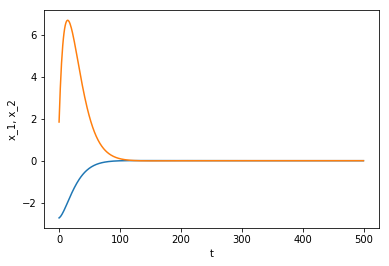

In [106]:
import matplotlib.pyplot as plt
plt.plot(trajectory)
plt.xlabel('t')
plt.ylabel('x_1, x_2')
plt.show()